# Data

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import StandardScaler
import h5py
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
print(torch.__version__)

2.6.0+cu124


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/My Drive/underwater/data

In [4]:
# # Training configuration
# config = {
#     'batch_size': 256,
#     'lr': 3e-4,
#     'epochs': 50,
#     'weight_decay': 1e-6,
#     'patience': 15
# }

config = {
    'batch_size': 128,          # Smaller batch size
    'lr': 1e-4,                 # Lower learning rate
    'epochs': 75,               # Increased epochs to allow for slower convergence
    'weight_decay': 1e-6,
    'patience': 15,
    'optimizer': 'Adam',        # Switch to Adam
    'loss_function': 'Huber'    # Use HuberLoss
}

In [5]:

def visualize_results(targets_denorm, predictions_denorm):
    # Create subplots for scatter plots
    plt.figure(figsize=(18, 20))
    
    print("Targets shape:", targets_denorm.shape)
    print("Predictions shape:", predictions_denorm.shape)

    # Scatter plots of True vs Predicted values
    for i in range(8):
        plt.subplot(4, 2, i+1)
        true = targets_denorm[:, i]
        pred = predictions_denorm[:, i]
        plt.scatter(true, pred, alpha=0.3, label='Samples')
        plt.plot([min(true), max(true)], [min(true), max(true)], 'r--', label='Perfect Prediction')
        plt.xlabel(f'True Value (Thruster {i+1})')
        plt.ylabel(f'Predicted Value (Thruster {i+1})')
        plt.title(f'Thruster {i+1} - True vs Predicted')
        plt.legend()
        plt.grid(True)

        # Add R² and MAE to plot
        r2 = r2_score(true, pred)
        mae = mean_absolute_error(true, pred)
        plt.text(0.05, 0.9, f'R²: {r2:.2f}\nMAE: {mae:.2f}',
                transform=plt.gca().transAxes,
                bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.savefig('true_vs_predicted_scatter.png')
    plt.show()

    # Create sample comparison plot (first 100 samples)
    plt.figure(figsize=(18, 20))
    sample_indices = np.arange(100)

    for i in range(8):
        plt.subplot(4, 2, i+1)
        plt.plot(sample_indices, targets_denorm[:100, i], 'b-', label='True')
        plt.plot(sample_indices, predictions_denorm[:100, i], 'r--', label='Predicted')
        plt.xlabel('Sample Index')
        plt.ylabel('Value')
        plt.title(f'Thruster {i+1} - First 100 Samples')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.savefig('sample_comparison.png')
    plt.show()

    # Residuals distribution
    plt.figure(figsize=(18, 20))
    residuals = targets_denorm - predictions_denorm

    for i in range(8):
        plt.subplot(4, 2, i+1)
        plt.hist(residuals[:, i], bins=50, alpha=0.7)
        plt.xlabel('Residual (True - Predicted)')
        plt.ylabel('Frequency')
        plt.title(f'Thruster {i+1} - Residual Distribution')
        plt.grid(True)

    plt.tight_layout()
    plt.savefig('residual_distribution.png')
    plt.show()

# Configuration for feature normalization
class FeatureNormalizer:
    def __init__(self, x_scales, y_scales):
        self.x_scales = x_scales
        self.y_scales = y_scales

    def normalize_x(self, x):
        return x / self.x_scales

    def denormalize_x(self, x_norm):
        return x_norm * self.x_scales

    def normalize_y(self, y):
        return y / self.y_scales

    def denormalize_y(self, y_norm):
        return y_norm * self.y_scales

NU_MIN: float  = 0.0
NU_MAX: float  = 10.0
D_LOC_MAX: float  = 5.0
DEPTH_MIN: float  = -1.0
DEPTH_MAX: float  = 20.0
ZERO: float = 1.0

# Example scaling configuration
X_SCALE_FACTORS = [
    np.pi/4, np.pi/4, np.pi,
    NU_MAX, NU_MAX, NU_MAX,
    0.05, 0.05, 0.1,
]

X_REF_SCALE_FACTORS = [
    D_LOC_MAX, D_LOC_MAX, DEPTH_MAX,
    ZERO, ZERO, np.pi,
    NU_MAX, NU_MAX, ZERO,
    ZERO, ZERO, ZERO
]

x_ref_scale = np.array(X_REF_SCALE_FACTORS*41, dtype=np.float32)

x_scales = np.hstack((X_SCALE_FACTORS, x_ref_scale))

Y_SCALE_FACTORS = [80.0, 80.0, 80.0, 80.0,  # Main thrusters
                   30.0, 30.0, 30.0, 30.0]   # Tunnel thrusters
normalizer = FeatureNormalizer(x_scales, np.array(Y_SCALE_FACTORS, dtype=np.float32))

In [6]:
with h5py.File('data/merged_rows.h5', 'r') as hf:
    x_current = hf['x_current'][:]
    x_ref = hf['x_ref'][:]
    u_opt = hf['u_opt'][:]

x_path_3d = x_ref.reshape(x_ref.shape[0], 12, 41).transpose(0, 2, 1)

for i in range(x_current.shape[0]):
    # Create an array of the current [N, E, D, 0, 0, ...]
    pos_array = np.zeros(12, dtype=np.float32)
    pos_array[:3] = x_current[i, :3]
    # Subtract to make the entire path relative
    x_path_3d[i] -= pos_array

x_ref_relative = x_path_3d.transpose(0, 2, 1).reshape(x_ref.shape)

X = np.hstack((x_current[:, 3:], x_ref_relative)).astype(np.float32)
y = u_opt.astype(np.float32)

SAMPLES_PER_SCENARIO = 100
num_samples = X.shape[0]
num_scenarios = num_samples // SAMPLES_PER_SCENARIO

scenario_ids = np.arange(num_scenarios)

train_val_ids, test_ids = train_test_split(
    scenario_ids, test_size=0.2, shuffle=True, random_state=42
)
train_ids, val_ids = train_test_split(
    train_val_ids, test_size=0.25, shuffle=True, random_state=42 # 0.25 * 0.8 = 0.2
)

def get_data_from_ids(scenario_ids, X_full, y_full):
    indices = np.concatenate([np.arange(i * SAMPLES_PER_SCENARIO, (i + 1) * SAMPLES_PER_SCENARIO) for i in scenario_ids])
    return X_full[indices], y_full[indices]

X_train, y_train = get_data_from_ids(train_ids, X, y)
X_val, y_val = get_data_from_ids(val_ids, X, y)
X_test, y_test = get_data_from_ids(test_ids, X, y)

print(f"Total scenarios: {num_scenarios}")
print(f"Train scenarios: {len(train_ids)}, Val scenarios: {len(val_ids)}, Test scenarios: {len(test_ids)}")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

scaler_X = StandardScaler()
scaler_y = StandardScaler()

scaler_X.fit(X_train)
scaler_y.fit(y_train)

joblib.dump(scaler_X, 'scaler_X.gz')
joblib.dump(scaler_y, 'scaler_y.gz')
print("Fitted scalers have been saved.")

X_train_norm = scaler_X.transform(X_train)
X_val_norm = scaler_X.transform(X_val)
X_test_norm = scaler_X.transform(X_test)

y_train_norm = scaler_y.transform(y_train)
y_val_norm = scaler_y.transform(y_val)

y_test_norm = scaler_y.transform(y_test)

# To denormalize predictions:
# predictions_denorm = scaler_y.inverse_transform(predictions_norm)

train_dataset = TensorDataset(torch.from_numpy(X_train_norm).float(), torch.from_numpy(y_train_norm).float())
val_dataset = TensorDataset(torch.from_numpy(X_val_norm).float(), torch.from_numpy(y_val_norm).float())
test_dataset = TensorDataset(torch.from_numpy(X_test_norm).float(), torch.from_numpy(y_test_norm).float())

Total scenarios: 1129
Train scenarios: 677, Val scenarios: 226, Test scenarios: 226
X_train shape: (67700, 501), y_train shape: (67700, 8)
Fitted scalers have been saved.


# Network

In [7]:
# Dropout layers are disabled temporarily to see if the training loss drops below the validation loss. If it does, your dropout rates are likely too high.

class FossenNet(nn.Module):
    def __init__(self):
        super(FossenNet, self).__init__()
        # State processing branch (current state: 9 features)
        self.state_net = nn.Sequential(
            nn.Linear(9, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            # nn.Dropout(0.2), # Temporarily disabled
            nn.Linear(64, 32),
            nn.LeakyReLU(0.1)
        )
        
        # Reference trajectory processing (492 features -> 41 timesteps x 12 features)
        self.lstm = nn.LSTM(
            input_size=12,
            hidden_size=128,
            num_layers=2,
            batch_first=True,
            dropout=0.2  # Note: This dropout is within the LSTM layers and is often beneficial
        )
        self.ref_fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1)
        )
        
        # --- MODIFIED: Increased Capacity ---
        # Combined processing
        self.combined_net = nn.Sequential(
            nn.Linear(32 + 64, 256),  # Concatenated features -> Increased width
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            # nn.Dropout(0.3), # Temporarily disabled
            nn.Linear(256, 128),      # Added another layer for more depth
            nn.LeakyReLU(0.1),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 8)
        )
        
        # Initialize weights (no changes here)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.1)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight_ih' in name:
                        nn.init.xavier_uniform_(param.data)
                    elif 'weight_hh' in name:
                        nn.init.orthogonal_(param.data)
                    elif 'bias' in name:
                        param.data.fill_(0)
                        n = param.size(0)
                        param.data[n//4:n//2].fill_(1)

    def forward(self, x):
        state = x[:, :9]
        ref = x[:, 9:9+492]
        
        state_out = self.state_net(state)
        
        batch_size = x.size(0)
        ref = ref.view(batch_size, 41, 12)
        lstm_out, _ = self.lstm(ref)
        ref_out = lstm_out[:, -1, :]
        ref_out = self.ref_fc(ref_out)
        
        combined = torch.cat((state_out, ref_out), dim=1)
        return self.combined_net(combined)

def train(config, train_dataset, val_dataset):
    model = FossenNet()
    
    # --- MODIFIED: Select Loss Function based on config ---
    if config['loss_function'] == 'Huber':
        criterion = nn.HuberLoss()
    else: # Default to MSE
        criterion = nn.MSELoss()

    # --- MODIFIED: Select Optimizer based on config ---
    if config['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    else: # Default to AdamW
        optimizer = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
        
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=7, factor=0.5)

    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], num_workers=2)

    best_loss = float('inf')
    no_improve = 0
    
    print("--- Starting Training ---")
    print(f"Configuration: {config}")


    for epoch in range(config['epochs']):
        # Training phase
        model.train()
        train_loss = 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            pred = model(x_batch)
            loss = criterion(pred, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                pred = model(x_val)
                val_loss += criterion(pred, y_val).item()

        avg_train = train_loss / len(train_loader)
        avg_val = val_loss / len(val_loader)
        scheduler.step(avg_val)

        # Early stopping check
        if avg_val < best_loss:
            best_loss = avg_val
            no_improve = 0
            torch.save(model.state_dict(), 'best_model_huber_adam.pth') # Save with a descriptive name
        else:
            no_improve += 1

        if no_improve >= config['patience']:
            print(f"Early stopping at epoch {epoch+1}")
            break

        print(f"Epoch {epoch+1}/{config['epochs']} | "
              f"Train Loss: {avg_train:.6f} | Val Loss: {avg_val:.6f} | "
              f"LR: {optimizer.param_groups[0]['lr']:.2e}")

    model.to('cuda')
    scripted_model = torch.jit.script(model)
    scripted_model.save('fossen_net_scripted.pt')

def evaluate_test_set():
    model = FossenNet()
    model.load_state_dict(torch.load('best_model_huber_adam.pth'))
    model.eval()

    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)

    predictions = []
    targets = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            pred = model(x_batch)
            predictions.append(pred.numpy())
            targets.append(y_batch.numpy())

    predictions = np.vstack(predictions)
    targets = np.vstack(targets)

    # Denormalize
    predictions_denorm = normalizer.denormalize_y(predictions)
    targets_denorm = normalizer.denormalize_y(targets)

    # Calculate metrics
    metrics = {
        'MAE': mean_absolute_error(targets_denorm, predictions_denorm),
        'MSE': mean_squared_error(targets_denorm, predictions_denorm),
        'RMSE': np.sqrt(mean_squared_error(targets_denorm, predictions_denorm)),
        'R2': r2_score(targets_denorm, predictions_denorm)
    }

    # Per-thruster metrics
    thruster_metrics = []
    for i in range(8):
        thruster_metrics.append({
            'Thruster': i+1,
            'MAE': mean_absolute_error(targets_denorm[:, i], predictions_denorm[:, i]),
            'MSE': mean_squared_error(targets_denorm[:, i], predictions_denorm[:, i]),
            'RMSE': np.sqrt(mean_squared_error(targets_denorm[:, i], predictions_denorm[:, i])),
            'R2': r2_score(targets_denorm[:, i], predictions_denorm[:, i])
        })

    return metrics, thruster_metrics, predictions_denorm, targets_denorm

# Train

--- Starting Training ---
Configuration: {'batch_size': 128, 'lr': 0.0001, 'epochs': 75, 'weight_decay': 1e-06, 'patience': 15, 'optimizer': 'Adam', 'loss_function': 'Huber'}
Epoch 1/75 | Train Loss: 0.150337 | Val Loss: 0.086661 | LR: 1.00e-04
Epoch 2/75 | Train Loss: 0.084533 | Val Loss: 0.066146 | LR: 1.00e-04
Epoch 3/75 | Train Loss: 0.071245 | Val Loss: 0.055543 | LR: 1.00e-04
Epoch 4/75 | Train Loss: 0.062916 | Val Loss: 0.050247 | LR: 1.00e-04
Epoch 5/75 | Train Loss: 0.057193 | Val Loss: 0.046079 | LR: 1.00e-04
Epoch 6/75 | Train Loss: 0.052331 | Val Loss: 0.042581 | LR: 1.00e-04
Epoch 7/75 | Train Loss: 0.048782 | Val Loss: 0.038022 | LR: 1.00e-04
Epoch 8/75 | Train Loss: 0.045449 | Val Loss: 0.037592 | LR: 1.00e-04
Epoch 9/75 | Train Loss: 0.042695 | Val Loss: 0.034401 | LR: 1.00e-04
Epoch 10/75 | Train Loss: 0.040181 | Val Loss: 0.031952 | LR: 1.00e-04
Epoch 11/75 | Train Loss: 0.037855 | Val Loss: 0.030776 | LR: 1.00e-04
Epoch 12/75 | Train Loss: 0.035529 | Val Loss: 0.0282

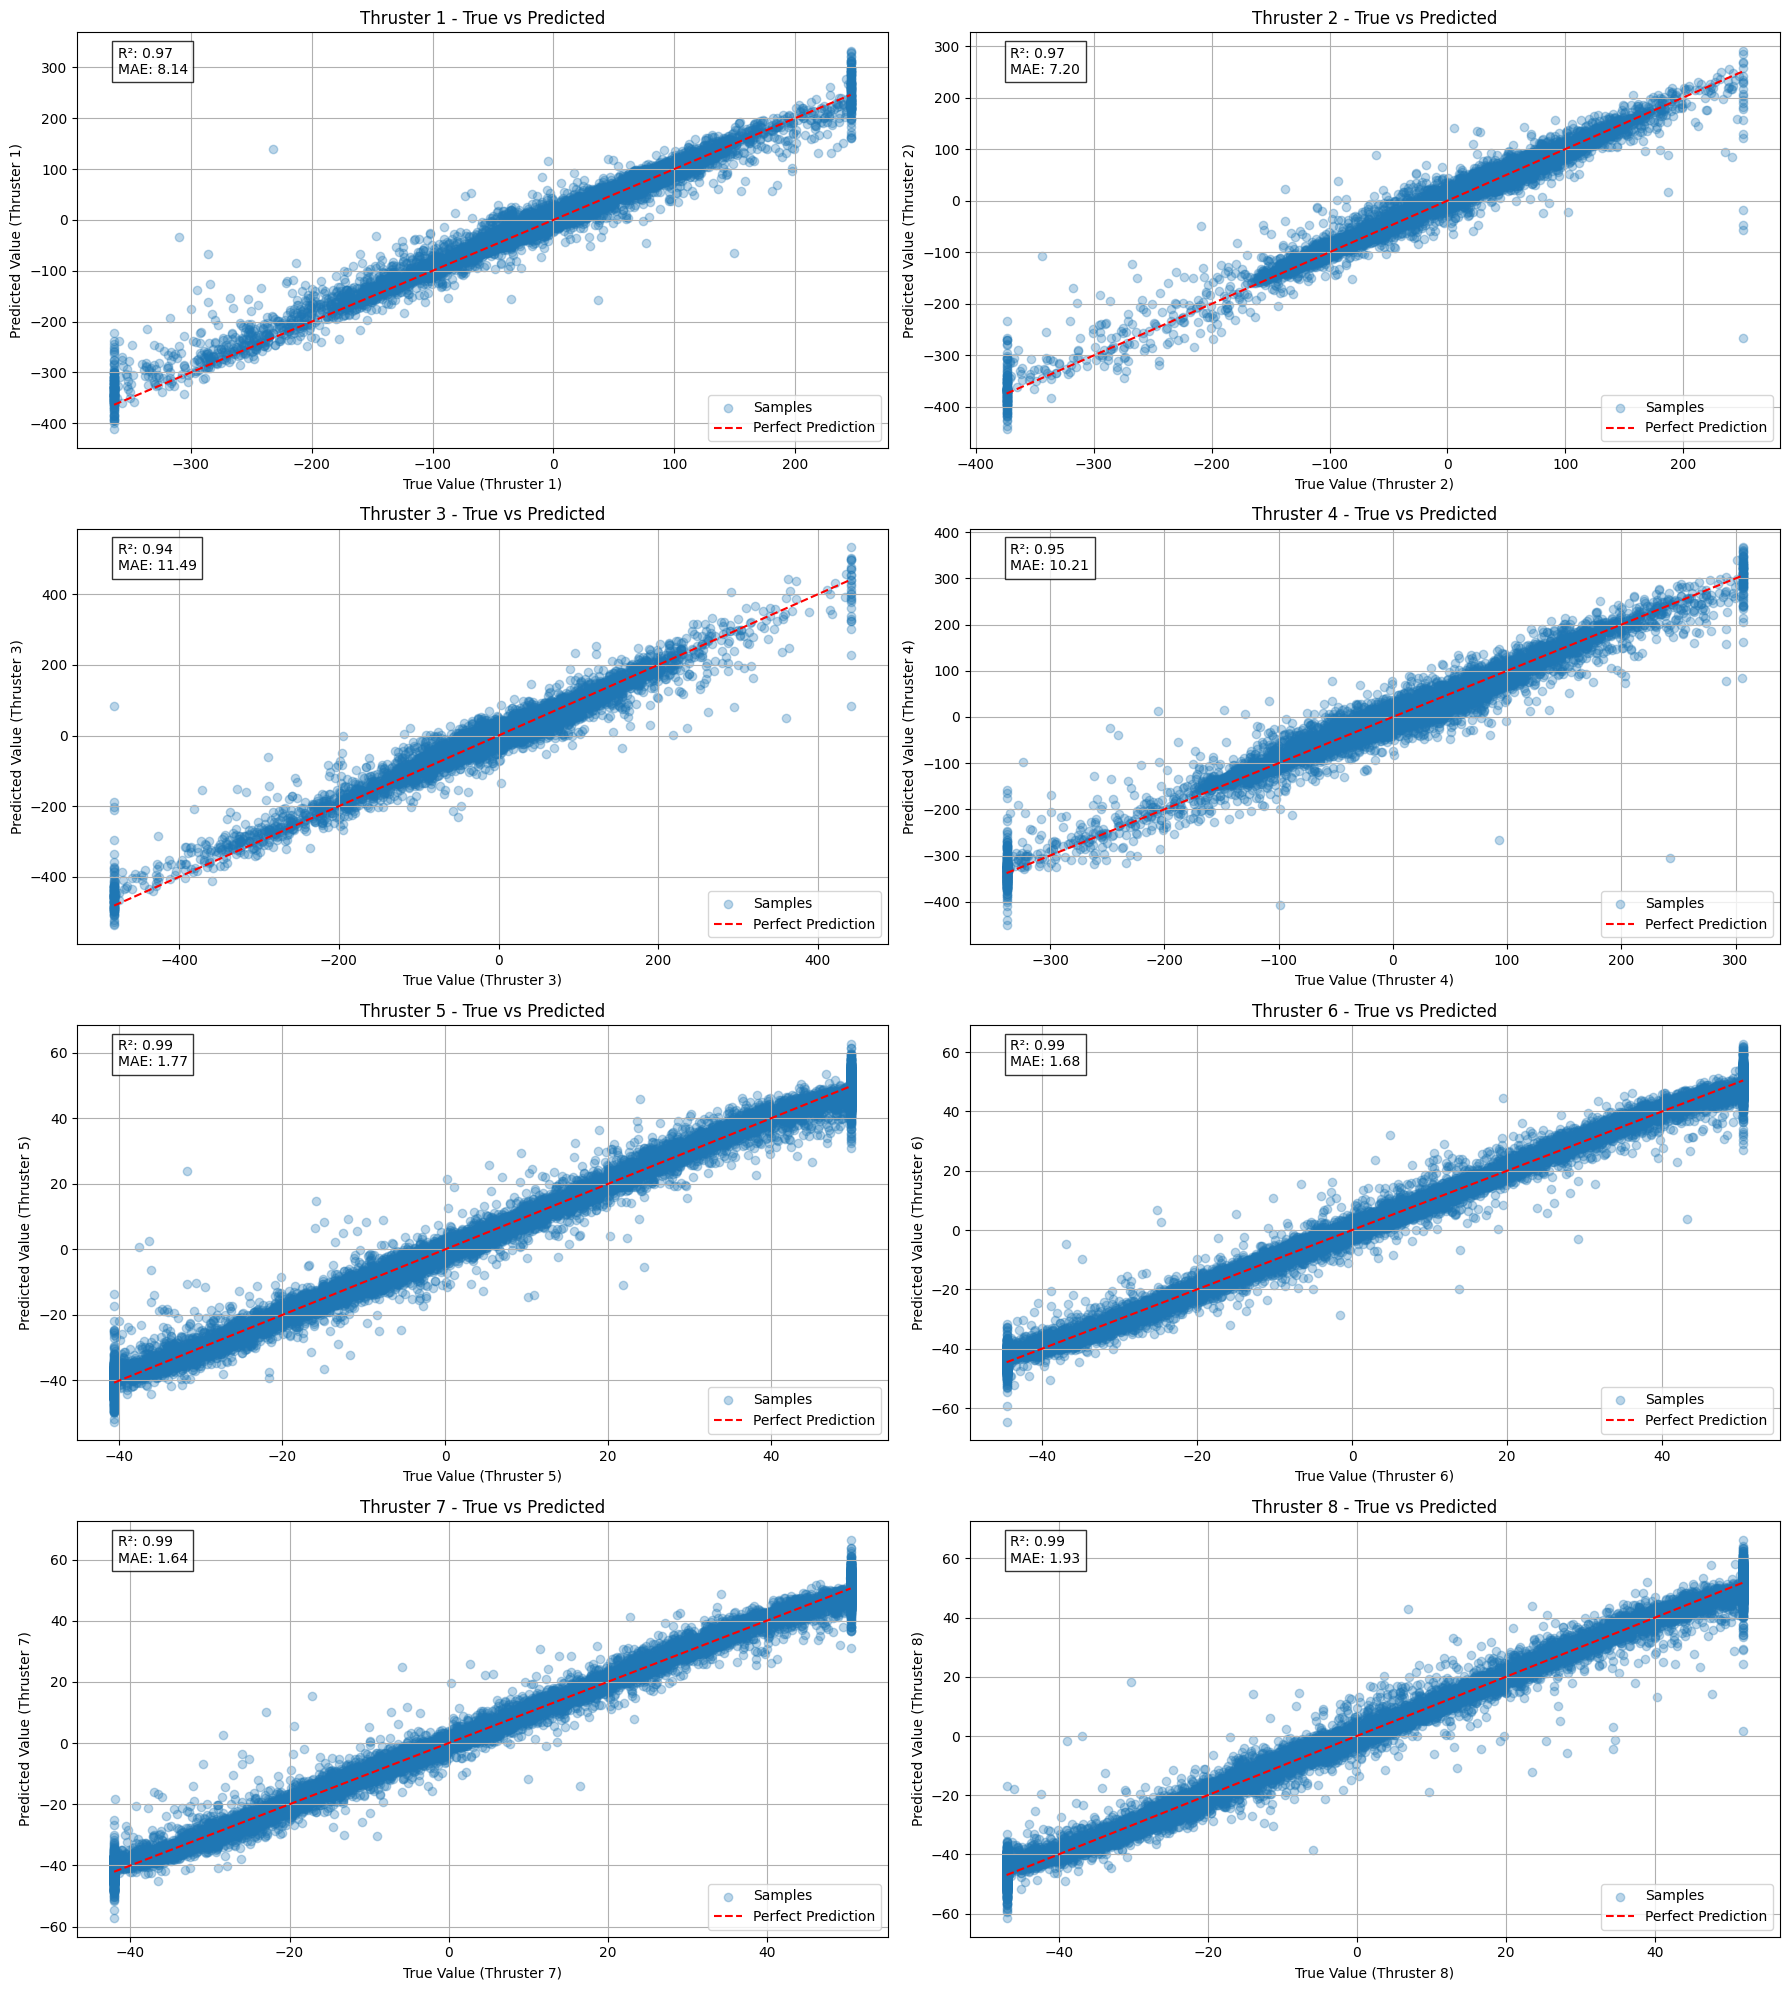

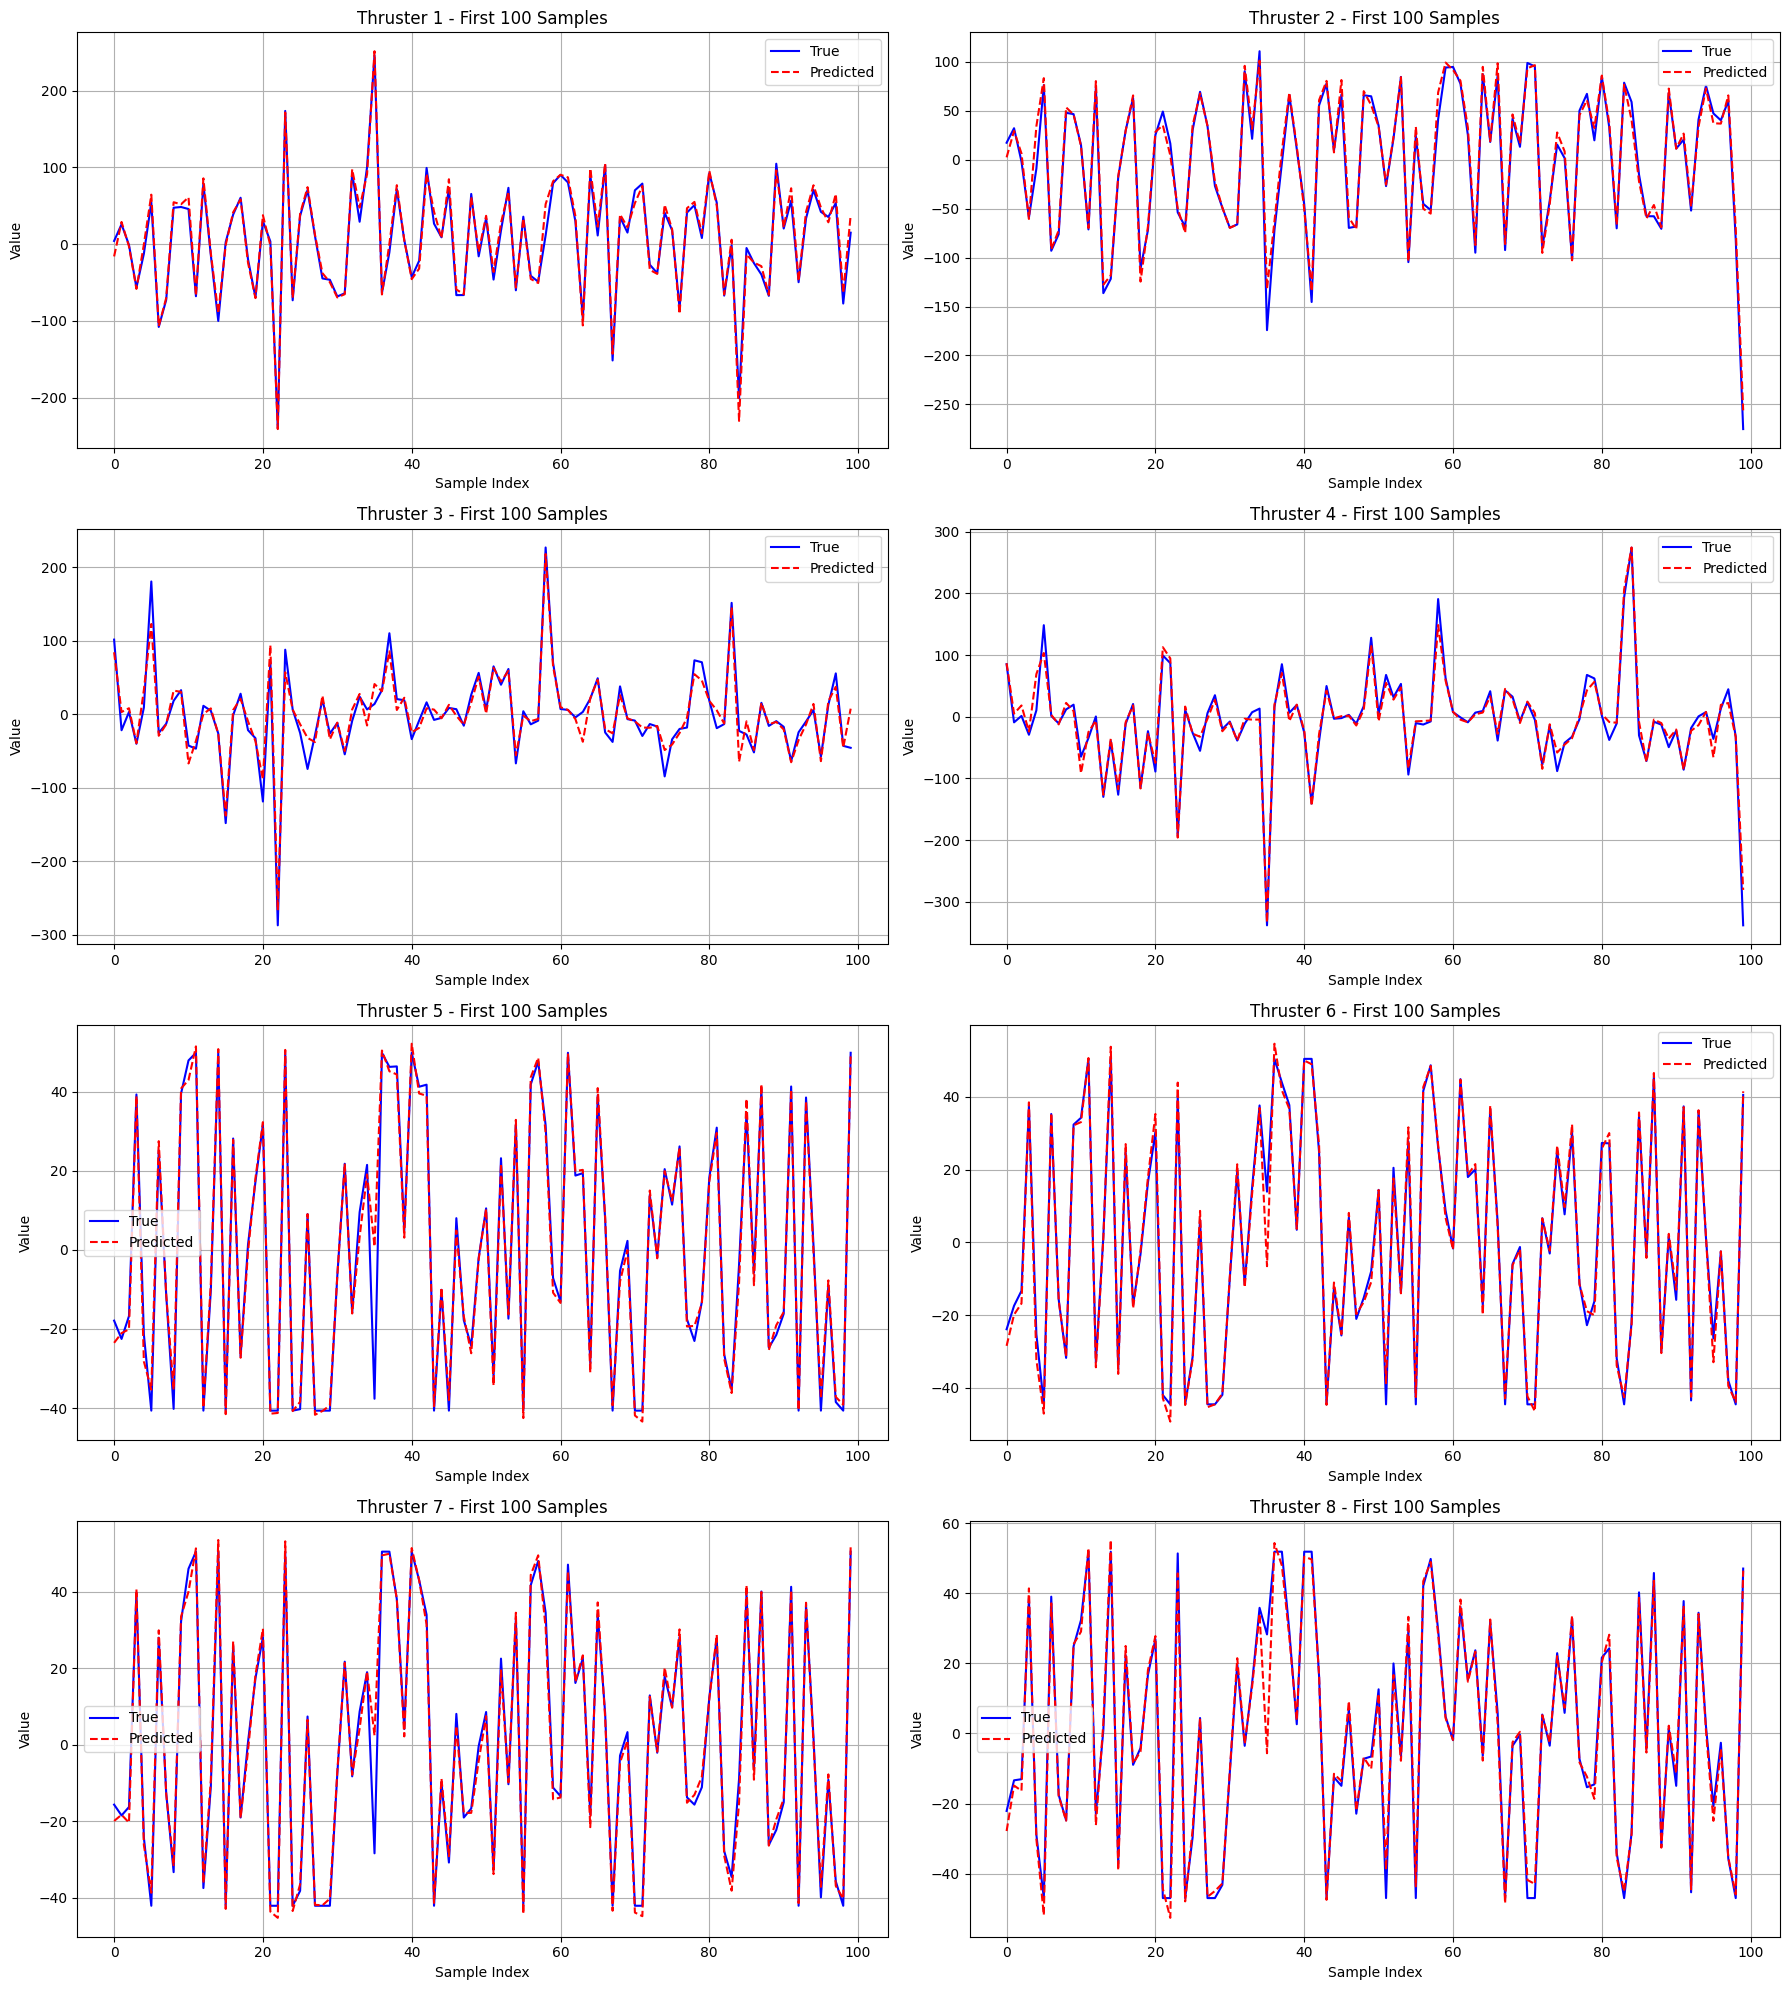

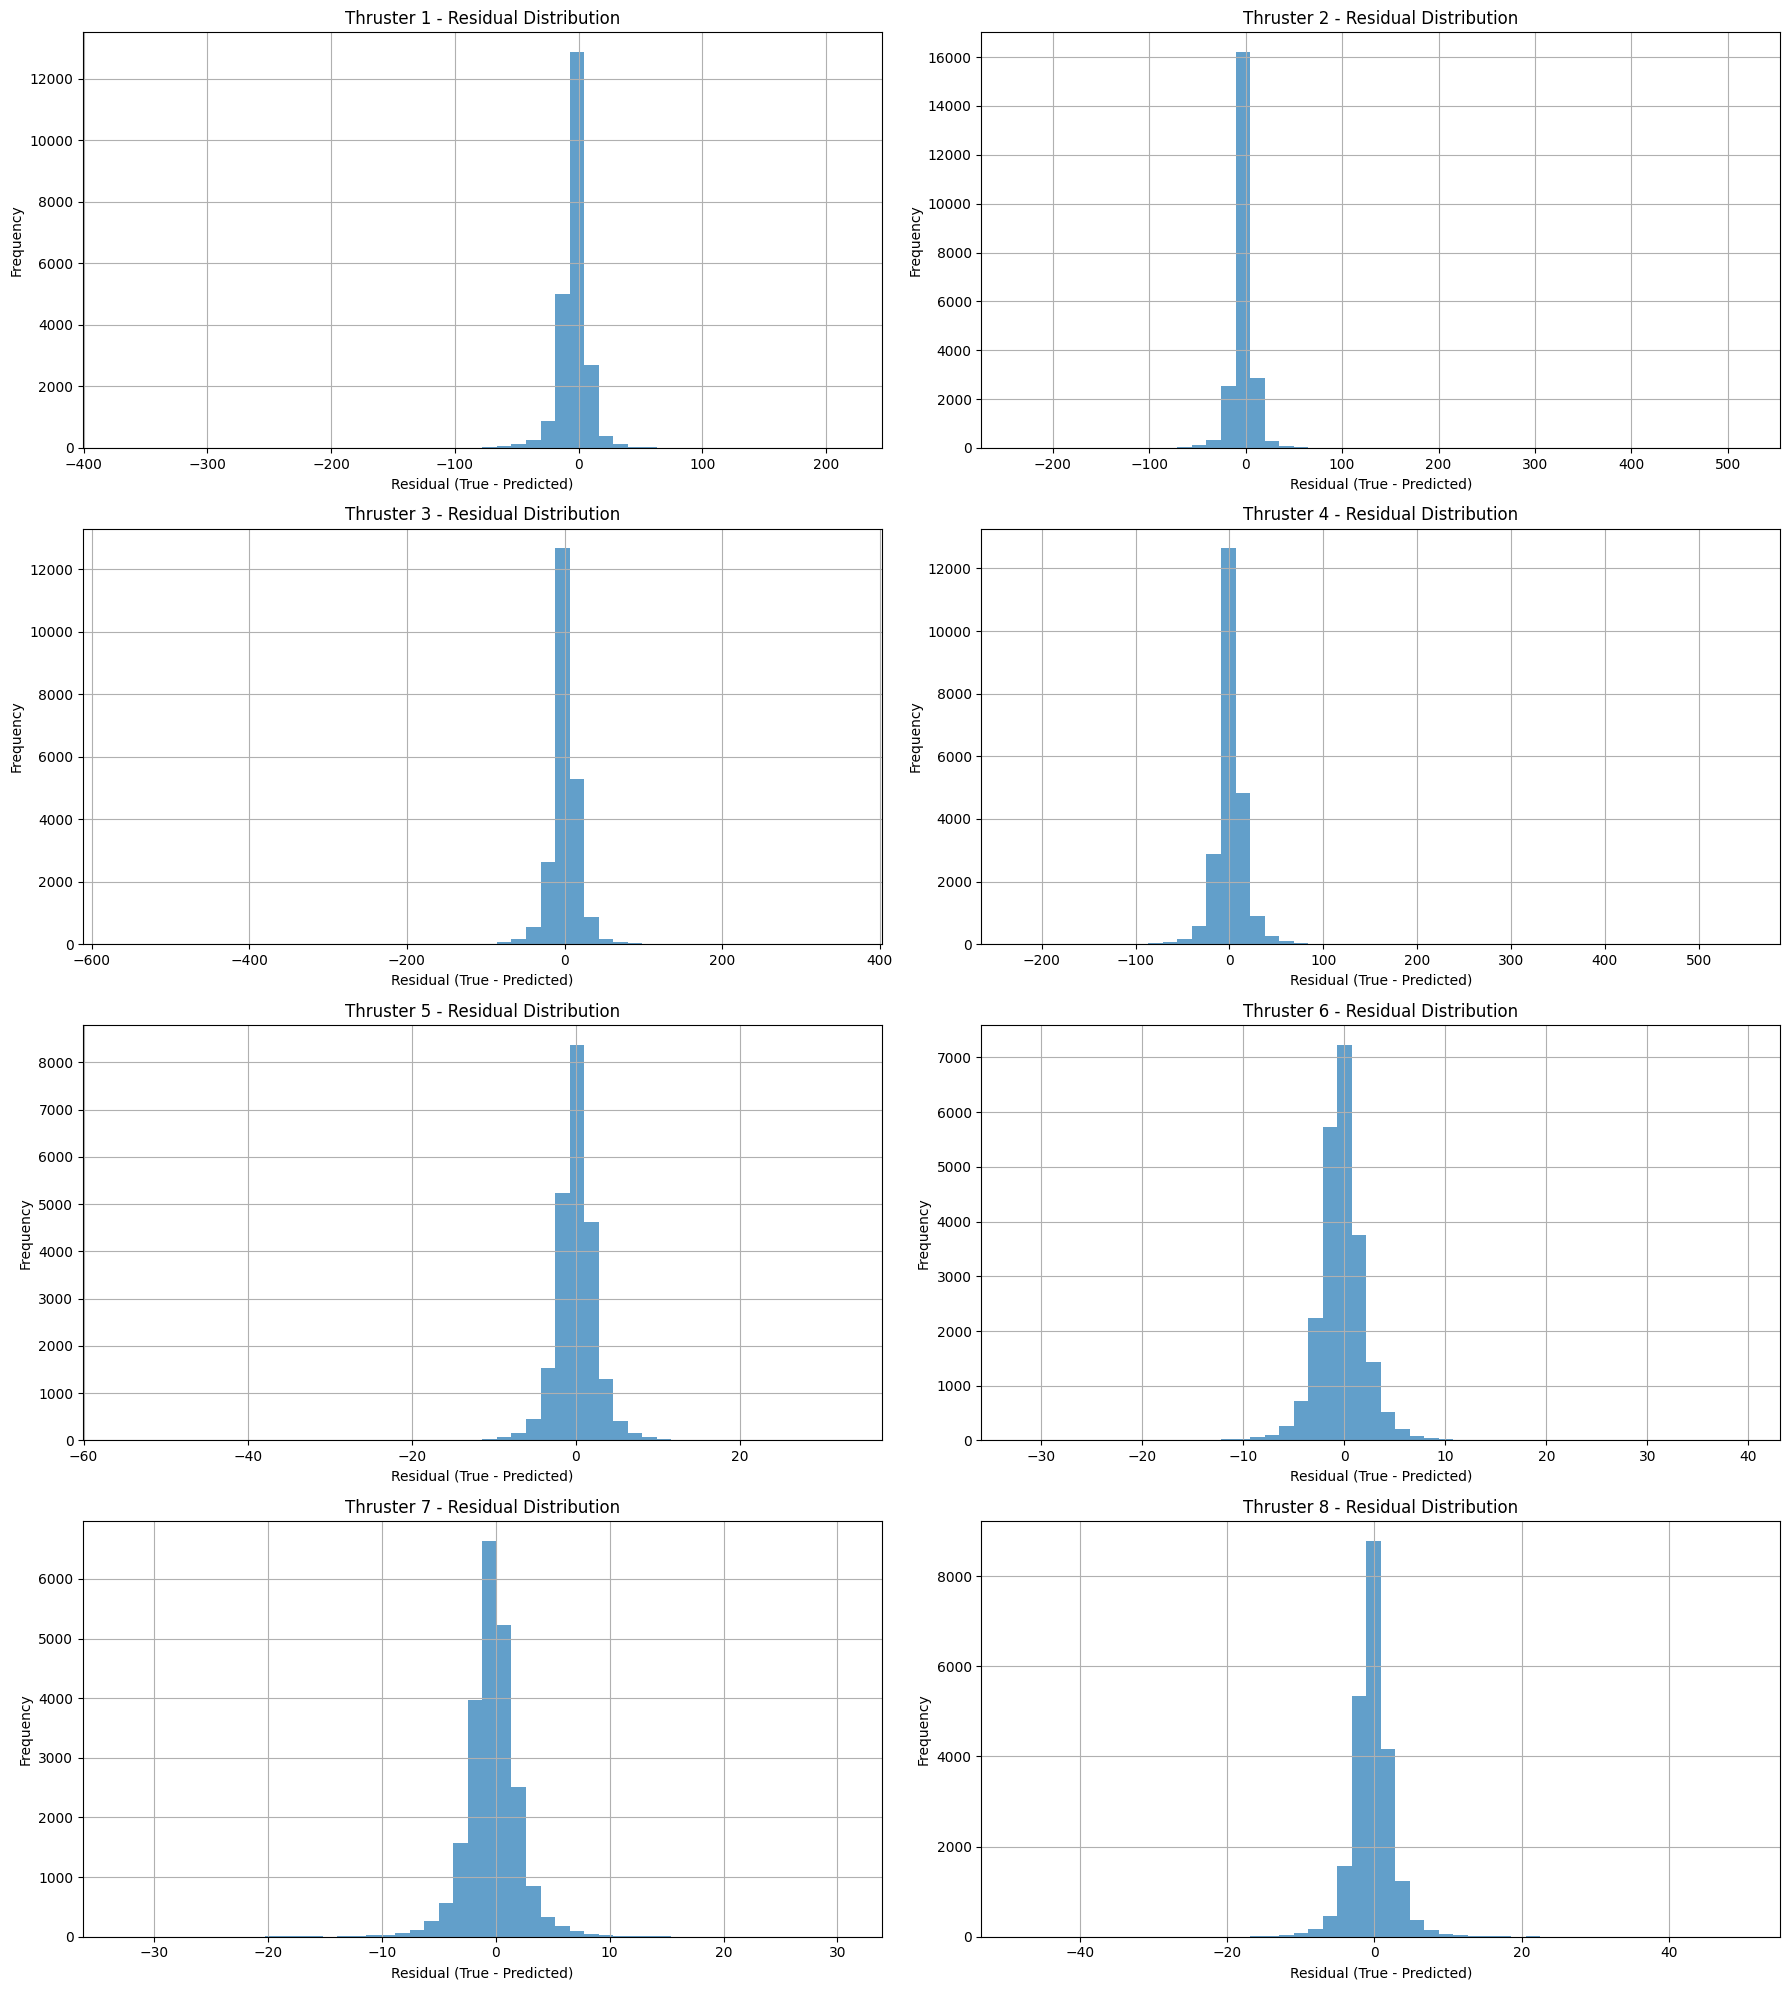

In [8]:
if __name__ == '__main__':
    train(config, train_dataset, val_dataset)

    # Evaluate on test set
    metrics, thruster_metrics, preds, targets = evaluate_test_set()

    print("\nFinal Test Set Metrics:")
    print(f"MAE: {metrics['MAE']:.4f}")
    print(f"MSE: {metrics['MSE']:.4f}")
    print(f"RMSE: {metrics['RMSE']:.4f}")
    print(f"R²: {metrics['R2']:.4f}")

    print("\nPer-Thruster Metrics:")
    for tm in thruster_metrics:
        print(f"\nThruster {tm['Thruster']}:")
        print(f"MAE: {tm['MAE']:.4f}  MSE: {tm['MSE']:.4f}")
        print(f"RMSE: {tm['RMSE']:.4f}  R²: {tm['R2']:.4f}")

    visualize_results(targets, preds)